Практическое задание:

взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)<br>
сделать обзорный анализ выбранного датасета<br>
сделать feature engineering<br>
обучить любой классификатор (какой вам нравится)<br>
разобраться с SHAP и построить важности признаков для:<br>
всего тестового набора данных (summary_plot - дать интерпретацию)<br>
- для топ 10%<br>
для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат<br>


Выбран
https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/

Описание
Attribute Information:

   1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use 
                                                        2=Long-term
                                                        3=Short-term

In [1]:
import shap
import xgboost as xgb

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
names=['wife_age','wife_education','husband_education','number_children',
       'wife_religion','wife_working','husband_occupation','stnd_of_living',
       'exposure','method_used']
df = pd.read_csv("cmc.data", header=None, names = names)
print(df.shape)
df.head(10)

(1473, 10)


,wife_age,wife_education,husband_education,number_children,wife_religion,wife_working,husband_occupation,stnd_of_living,exposure,method_used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
5,19,4,4,0,1,1,3,3,0,1
6,38,2,3,6,1,1,3,2,0,1
7,21,3,3,1,1,0,3,2,0,1
8,27,2,3,3,1,1,3,4,0,1
9,45,1,1,8,1,1,2,2,1,1


In [3]:
df['method_used'].value_counts()

1    629
3    511
2    333
Name: method_used, dtype: int64

In [4]:
# упростим модель для увеличения точности, объединим  2=Long-term и 3=Short-term, что даст нам сбалансированный бинарный таргет
df['method_used'] = df['method_used'].apply(lambda x: 0 if x == 1 else 1)
df['method_used'].value_counts()

1    844
0    629
Name: method_used, dtype: int64

In [5]:
features = names[:-1]
target = "method_used"

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

<b>Для данного набора возможно имеет смысл провести feature engineering только для возрвста превратив годы в промежутки лет, но тогда анализ результатов исследования показателей станет менее наглядным для анализа</b>

In [7]:
model = xgb.train( {"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)

# строим модель объЯсненияе в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# покажем объяснение первого примера (берем matplotlib=True для обхода Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [8]:
n=10
shap.force_plot(explainer.expected_value, shap_values[n,:], X_train.iloc[n,:])

In [9]:
shap_values

array([[ 0.01517657,  0.03811795,  0.0006259 , ..., -0.00301763,
         0.00741236,  0.00220071],
       [-0.0364809 ,  0.04974769,  0.00378693, ...,  0.00392403,
         0.00890029,  0.00544619],
       [ 0.03614362,  0.05985115, -0.00057982, ...,  0.00014723,
         0.02422152,  0.00102804],
       ...,
       [ 0.0281986 ,  0.04009401,  0.000648  , ...,  0.00409236,
         0.00021009,  0.00278026],
       [ 0.03411212,  0.03617975,  0.00356694, ...,  0.00409236,
        -0.01020666,  0.00277235],
       [-0.04942414,  0.02679478,  0.00076085, ...,  0.00021557,
         0.01179707,  0.00292825]], dtype=float32)

In [10]:
exp_sh=explainer.shap_interaction_values(X_train)

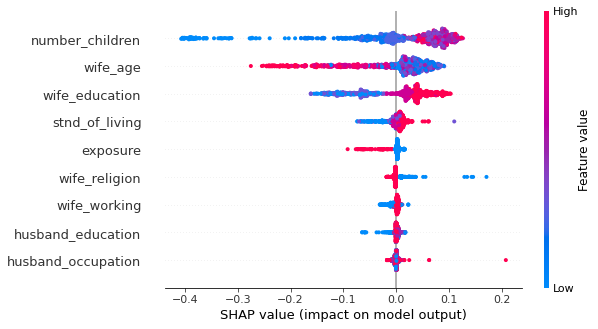

In [11]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

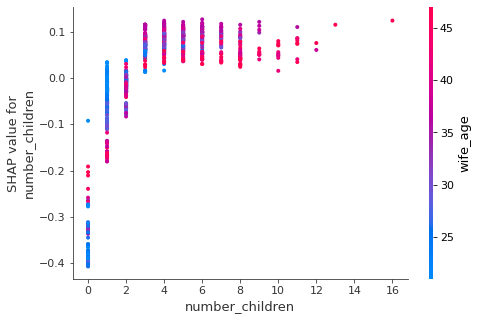

In [12]:
shap.dependence_plot("number_children", shap_values, X_train)

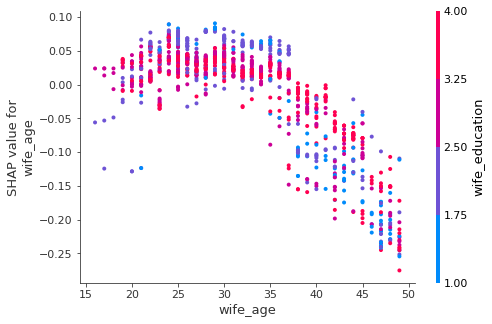

In [13]:
shap.dependence_plot("wife_age", shap_values, X_train)

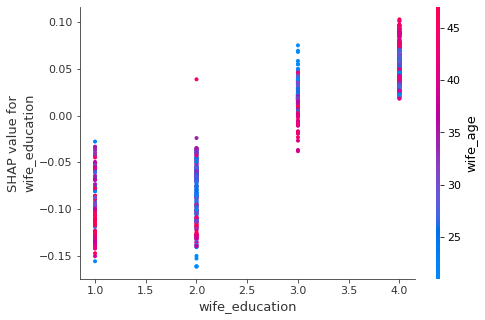

In [14]:
shap.dependence_plot("wife_education", shap_values, X_train)

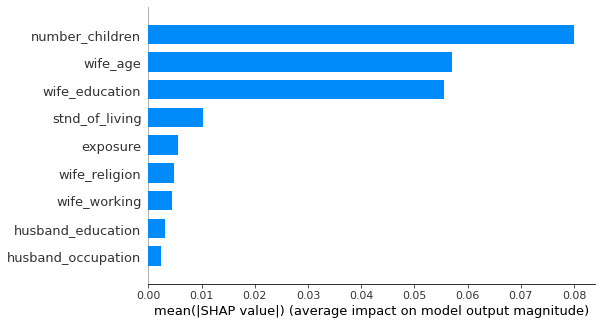

In [15]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

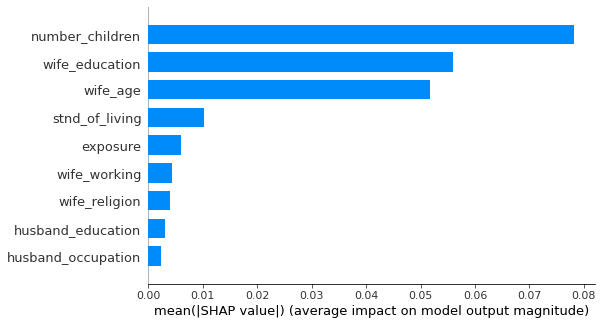

In [16]:
n = round(len(X_train)*0.1)
shap.summary_plot(shap_values[:n,:], X_train.iloc[:n,:], plot_type="bar")

In [17]:
n = len(X_train)
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])

In [18]:
n = round(len(X_train)*0.2)
shap.force_plot(explainer.expected_value, shap_values[:n,:], X_train.iloc[:n,:])

<b>Попался достаточно комфортный data frame для изучения. Исходя из метода Шепли можно видеть, что контрацепцию используют женщины чаще с большим количеством детей, с хорошим образованием и есть большая зависимость от возраста. Все остальные признаки влияют на принятие решения о контрацепции намного меньше. Выдвигаю теорию, что при повышении уровня образования в Индонезии применение контрацепции выростет, что за собой повлечет уменьшени рождаемости.</b>